In [3]:

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from torchsig.datasets.sigmf import SigmfDataModule
from torchsig.transforms.target_transforms import YOLOLabel
from torchsig.transforms.dataset_transforms import DatasetTransform, DatasetSignal
import torchsig.transforms.functional as F
from torchsig.transforms.base_transforms import Normalize

In [ ]:
# You can download SigMF datasets from IQEngine (https://iqengine.org/browser).
# For example, check out the "airbus-sigence" repository on IQEngine.
# Download both the .sigmf-meta and .sigmf-data files for each recording.
# Place both files in the "./sigmf" folder specified below.
# You can add as many SigMF recordings as you want, but note:
# *** All recordings must currently have the same sample rate for this example to work.

root = "./sigmf"
fft_size = 512
fft_stride_factor = 4

In [11]:
# custom spectrogram transform with stride factor
class Spectrogram(DatasetTransform):
    """Computes the spectogram of IQ data.

    Attributes:
        fft_size (int): The FFT size (number of bins) in the spectrogram

    """

    def __init__(
        self,
        fft_size: int,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.fft_size = fft_size
        # fft_stride is the number of data points to move or "hop" over when computing the next FF
        self.fft_stride = fft_size // fft_stride_factor

    def __call__(self, signal: DatasetSignal) -> DatasetSignal:
        signal.data = F.spectrogram(
            signal.data,
            self.fft_size,
            self.fft_stride,
        )
        self.update(signal)
        return signal


In [12]:
transforms = [Normalize(norm=np.inf), Spectrogram(fft_size=fft_size)]
target_transforms = [YOLOLabel()]


# Instantiate the data module
dm = SigmfDataModule(
    root=root,
    dataset="wideband",
    batch_size=2,
    num_workers=0,
    overwrite=True,
    transforms=transforms,
    target_transforms=target_transforms,
    fft_size=fft_size,
    num_iq_samples=fft_size**2 // fft_stride_factor,
)

# Run prepare_data (should create the YAML file)
dm.prepare_data()
dm.setup(stage='fit')

Found 1 matched SigMF file pairs
Converting 1 SigMF files to Zarr format...
Using overlap factor: 0.5 (50.0%)
Processing SIGINT_DAY_DEMO_all_16_Emitter_Noise...


/home/sigence/.pyenv/versions/selfRF/lib/python3.10/site-packages/torchsig/datasets/sigmf/sigmf_dataset_converter.py:276: UserWarning: Zero bandwidth for annotation {'core:freq_lower_edge': 1980020000.0, 'core:freq_upper_edge': 1980020000.0, 'core:label': 'Sim  GPS Jammer', 'core:sample_count': 80748, 'core:sample_start': 25749}. Setting to 1e-12 Hz.
  warnings.warn(
/home/sigence/.pyenv/versions/selfRF/lib/python3.10/site-packages/torchsig/datasets/sigmf/sigmf_dataset_converter.py:276: UserWarning: Zero bandwidth for annotation {'core:freq_lower_edge': 2012020000.0, 'core:freq_upper_edge': 2012020000.0, 'core:label': 'Sim  AIS', 'core:sample_count': 81921, 'core:sample_start': 1187840}. Setting to 1e-12 Hz.
  warnings.warn(
/home/sigence/.pyenv/versions/selfRF/lib/python3.10/site-packages/torchsig/datasets/sigmf/sigmf_dataset_converter.py:276: UserWarning: Zero bandwidth for annotation {'core:freq_lower_edge': 2012020000.0, 'core:freq_upper_edge': 2012020000.0, 'core:label': 'Sim  AIS

Conversion complete! Created 681 samples in sigmf/torchsig


Data shape: (512, 509)
Number of signals: 26
Labels:
(21, 0.05706024169921875, 0.3140243896484375, 0.0023956298828125, 0.0243902587890625)
(10, 0.07123565673828125, 0.8666666687011719, 0.0061492919921875, 0.00987655029296875)
(11, 0.0993499755859375, 0.804054052734375, 0.01239013671875, 0.0872236083984375)
(22, 0.10718536376953125, 0.27439024658203126, 0.0018463134765625, 0.079268310546875)
(13, 0.1350250244140625, 0.647420147705078, 0.01239013671875, 0.03685504150390625)
(24, 0.1495513916015625, 0.3278364074707031, 0.01153564453125, 0.04617415771484375)
(15, 0.16626739501953125, 0.7163904235839844, 0.0248260498046875, 0.03683243408203125)
(17, 0.18918609619140625, 0.4206842956542969, 0.0097808837890625, 0.03576983642578125)
(19, 0.25244903564453125, 0.4627811828613281, 0.0372772216796875, 0.04130880126953125)
(10, 0.30873870849609375, 0.8666666687011719, 0.0061492919921875, 0.00987655029296875)
(11, 0.33685302734375, 0.804054052734375, 0.01239013671875, 0.0872236083984375)
(21, 0.4195

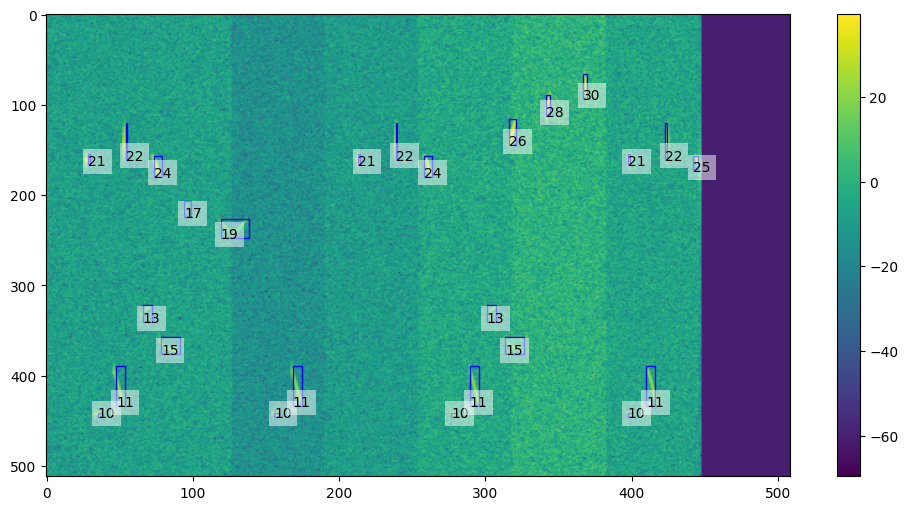

In [13]:
# Access the train dataset
train_dataset = dm.train
# Print dataset information
data, label = train_dataset[9]
print(f"Data shape: {data.shape}")
print(f"Number of signals: {len(label)}")
nl = "\n"
print(f"Labels:\n{nl.join(str(l) for l in label)}")

height, width = data.shape
fig = plt.figure(figsize=(12, 6))
fig.tight_layout()

ax = fig.add_subplot(1, 1, 1)
pos = ax.imshow(data, aspect='auto')

fig.colorbar(pos, ax=ax)


for t in label:
    classindex, xcenter, ycenter, normwidth, normheight = t

    actualwidth = width * normwidth
    actualheight = height * normheight

    actualxcenter = xcenter * width
    actualycenter = ycenter * height

    x_lowerleft = actualxcenter - (actualwidth / 2)
    y_lowerleft = actualycenter + (actualheight / 2)

    # print(x_lowerleft, y_lowerleft, actualwidth, actualheight)

    ax.add_patch(Rectangle(
        (x_lowerleft, y_lowerleft),
        actualwidth,
        -actualheight,
        linewidth=1,
        edgecolor='blue',
        facecolor='none'
    ))

    textDisplay = classindex
    ax.text(x_lowerleft, y_lowerleft, textDisplay,
            bbox=dict(facecolor='w', alpha=0.5, linewidth=0))

plt.show()
